MSE on original data: 26.43
MSE on drifted data: 24.86


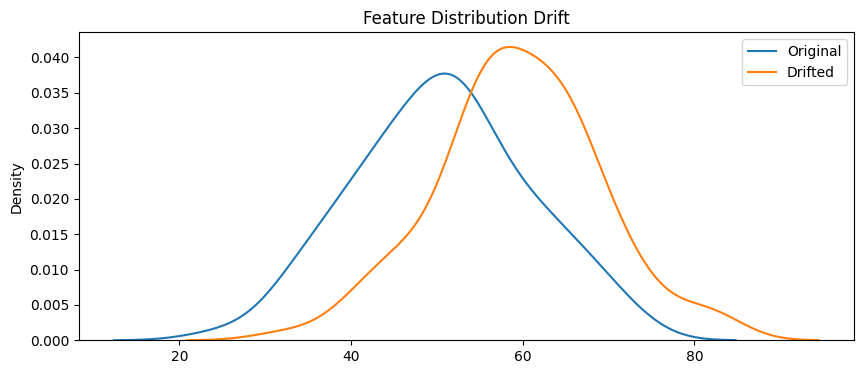

KS test statistic: 0.440, p-value: 0.000
Significant data drift detected.

Missing values per column:
id        0
age       1
income    1
dtype: int64

Data after imputing missing values:
   id   age   income
0   1  25.0  50000.0
1   2  32.0  60000.0
2   3  30.5  55000.0
3   4  40.0  52500.0
4   5  29.0  48000.0

Primary key 'id' is unique.


/tmp/ipykernel_35819/3906082761.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipykernel_35819/3906082761.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

TypeError: Validator.__init__() missing 1 required positional argument: 'execution_engine'

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp
import great_expectations as ge
from great_expectations.core import ExpectationSuite
from great_expectations.validator.validator import Validator

# ========== Part 1: Data Drift Detection & Visualization ==========

# Generate original training data
np.random.seed(0)
X_train = np.random.normal(loc=50, scale=10, size=(100, 1))
y_train = 2 * X_train.flatten() + np.random.normal(loc=0, scale=5, size=100)

# Generate drifted data (mean shifted)
X_drift = np.random.normal(loc=60, scale=10, size=(100, 1))
y_drift = 2 * X_drift.flatten() + np.random.normal(loc=0, scale=5, size=100)

# Train model on original data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on original and drifted data
y_pred_train = model.predict(X_train)
y_pred_drift = model.predict(X_drift)

# Calculate errors
mse_train = mean_squared_error(y_train, y_pred_train)
mse_drift = mean_squared_error(y_drift, y_pred_drift)

print(f"MSE on original data: {mse_train:.2f}")
print(f"MSE on drifted data: {mse_drift:.2f}")

# Visualize distribution drift for X feature
plt.figure(figsize=(10,4))
sns.kdeplot(X_train.flatten(), label='Original')
sns.kdeplot(X_drift.flatten(), label='Drifted')
plt.title('Feature Distribution Drift')
plt.legend()
plt.show()

# Statistical test for drift (KS test)
ks_stat, p_value = ks_2samp(X_train.flatten(), X_drift.flatten())
print(f"KS test statistic: {ks_stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Significant data drift detected.")
else:
    print("No significant data drift detected.")

# ========== Part 2: Basic Data Quality Checks ==========

# Example dataset
data = {
    'id': [1, 2, 3, 4, 5],
    'age': [25, 32, None, 40, 29],
    'income': [50000, 60000, 55000, None, 48000]
}
df = pd.DataFrame(data)

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Impute missing values with median
df['age'].fillna(df['age'].median(), inplace=True)
df['income'].fillna(df['income'].median(), inplace=True)

print("\nData after imputing missing values:")
print(df)

# Check primary key uniqueness (id)
if df['id'].is_unique:
    print("\nPrimary key 'id' is unique.")
else:
    print("\nPrimary key 'id' has duplicates!")

# ========== Part 3: Automated Validation with Great Expectations ==========

# Create an in-memory Great Expectations context
context = ge.get_context()

# Create an empty expectation suite
suite_name = "demo_suite"
suite = ExpectationSuite(suite_name)

# Create Validator with DataFrame and suite
validator = Validator(df=df, expectation_suite=suite)

# Define expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_not_be_null("income")
validator.expect_column_values_to_be_between("age", min_value=18, max_value=99)
validator.expect_column_values_to_be_between("income", min_value=30000, max_value=100000)
validator.expect_column_values_to_be_unique("id")

# Run validation
results = validator.validate()

print("\nGreat Expectations Validation Results:")
print(results)

